Skipping GOLD_I due to error: [Errno 2] No such file or directory: './data/GOLD_I/Players.csv'


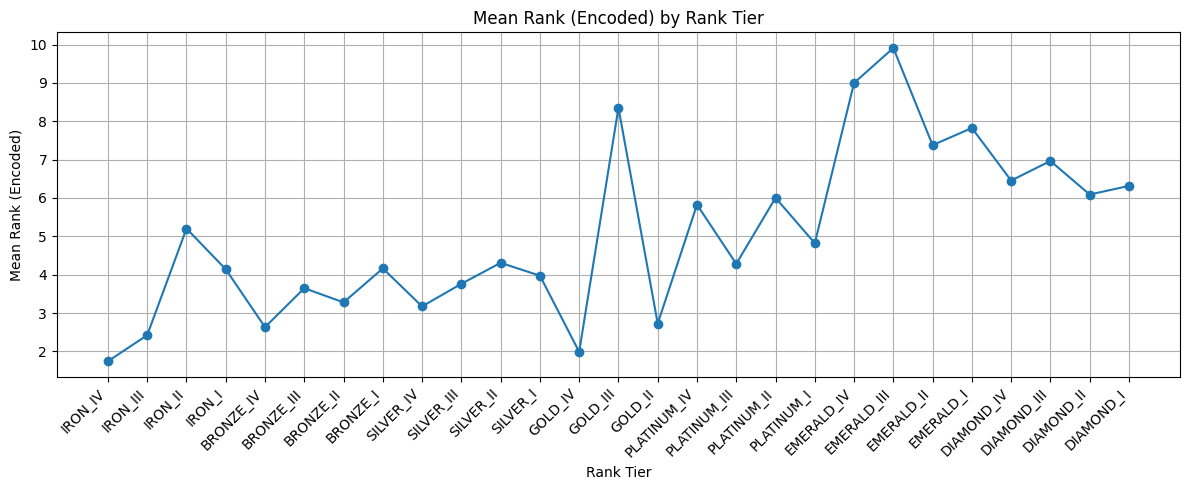

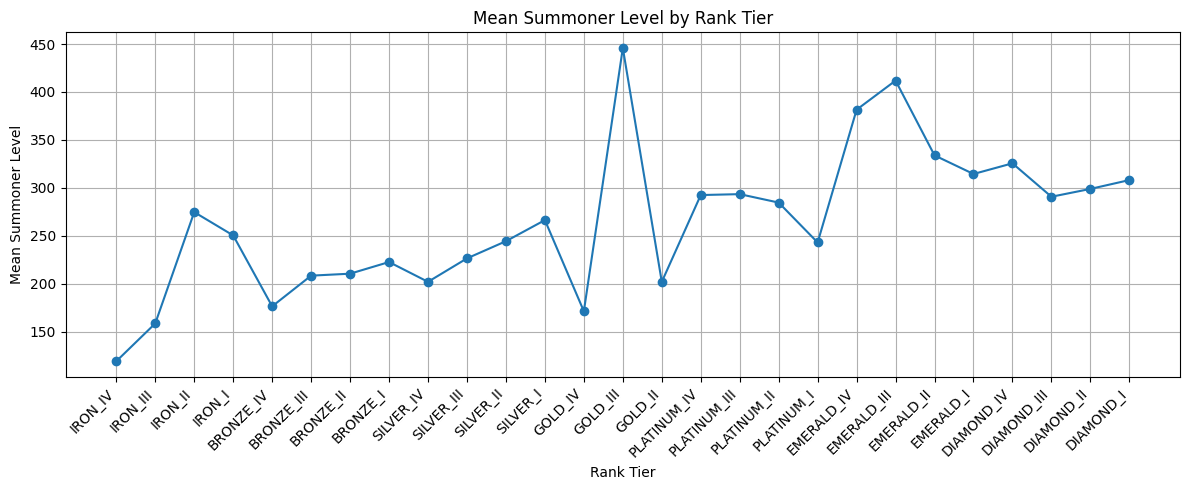

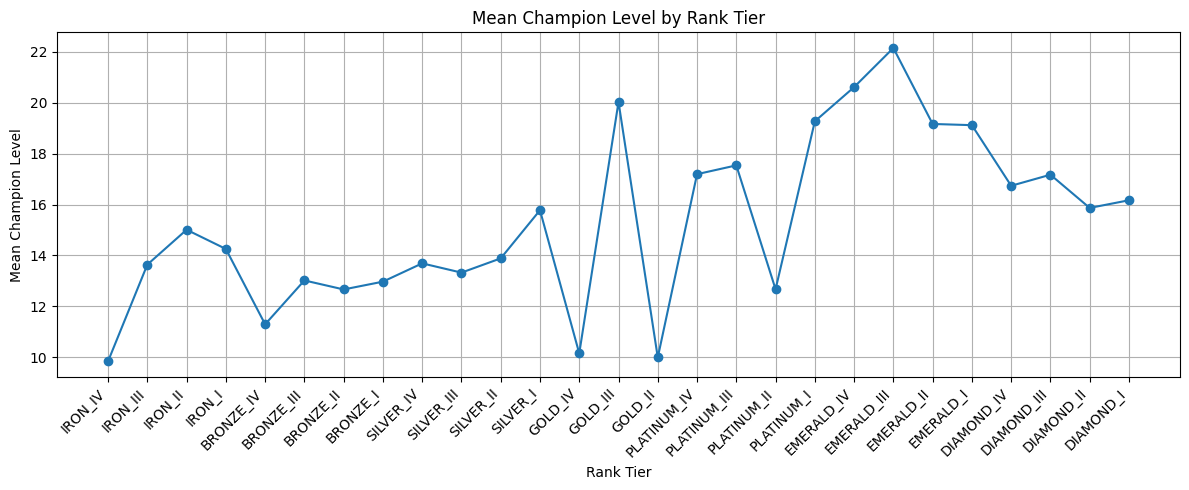

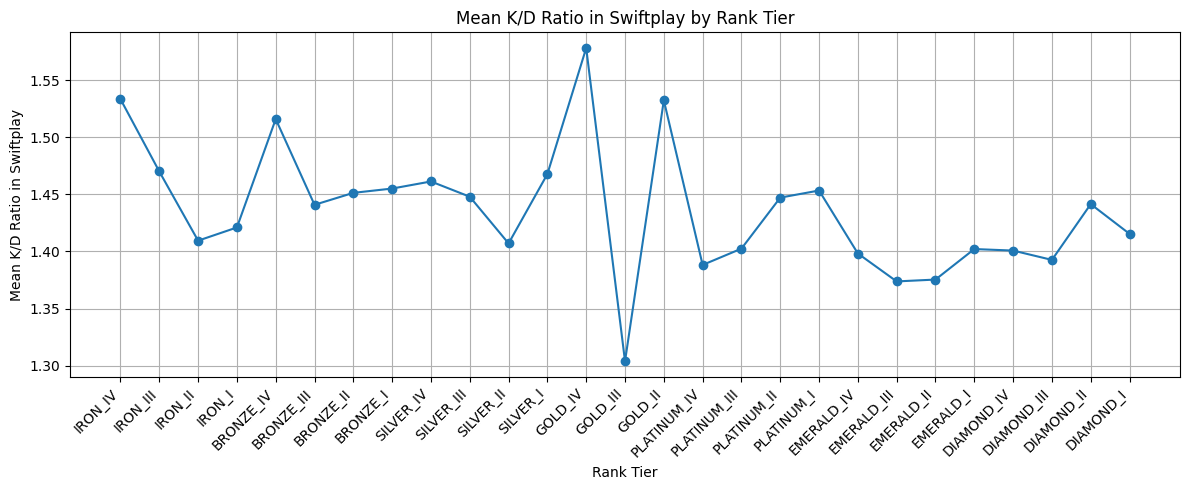

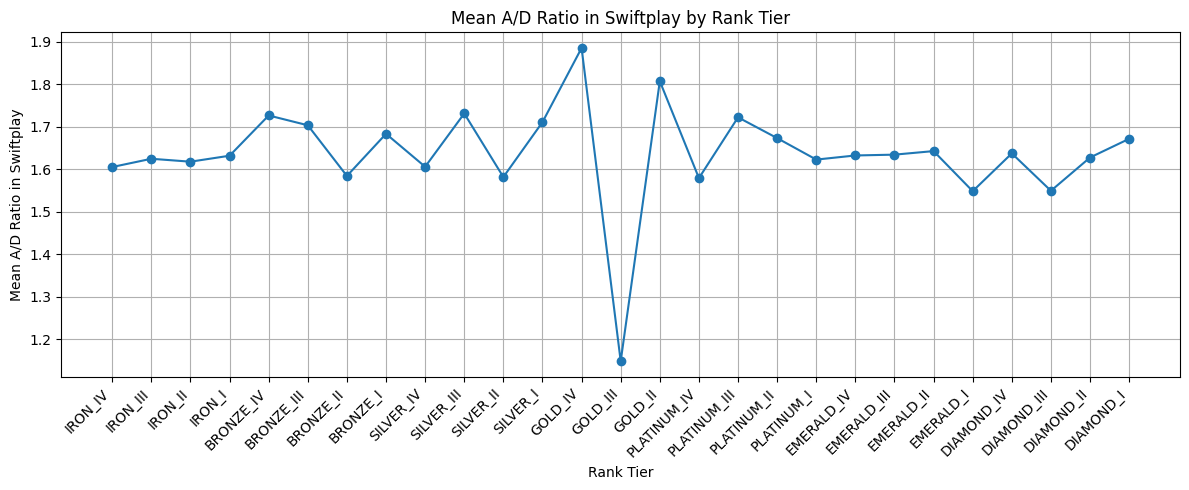

,rank_num,summonerLevel,championLevel,kd,ad,group,rank_string,rank_order_index
0,1.741624,119.079768,9.840464,1.533463,1.605185,IRON_IV,IRON IV,1
1,2.422994,158.547377,13.639660,1.470070,1.624600,IRON_III,IRON III,2
2,5.201547,274.678011,15.010497,1.409441,1.617733,IRON_II,IRON II,3
3,4.139762,250.366050,14.255350,1.421025,1.631775,IRON_I,IRON I,4
4,2.631673,176.371315,11.293227,1.515985,1.726509,BRONZE_IV,BRONZE IV,5
5,3.646927,208.391341,13.017598,1.440871,1.703416,BRONZE_III,BRONZE III,6
6,3.277005,210.434938,12.663280,1.451344,1.584152,BRONZE_II,BRONZE II,7
7,4.162037,222.591435,12.969444,1.455123,1.683328,BRONZE_I,BRONZE I,8
8,3.172395,201.940585,13.688848,1.461318,1.605820,SILVER_IV,SILVER IV,9
9,3.762088,226.402747,13.324542,1.447964,1.731170,SILVER_III,SILVER III,10


In [9]:
import pandas as pd
from common import preprocess, rank_order
import os
import matplotlib.pyplot as plt

def load_and_analyze_all_rank_tiers(folder_path):
    all_summary = []

    for rank in ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "EMERALD", "DIAMOND"]:
        for tier in ["IV", "III", "II", "I"]:
            group = f"{rank}_{tier}"
            try:
                # Load files
                players = pd.read_csv(os.path.join(folder_path, group, "Players.csv"))
                ranked_matches = pd.read_csv(os.path.join(folder_path, group, "RankedMatches.csv"))
                ranked_player_match_data = pd.read_csv(os.path.join(folder_path, group, "RankedPlayerMatchData.csv"))
                swiftplay_matches = pd.read_csv(os.path.join(folder_path, group, "SwiftplayMatches.csv"))
                swiftplay_player_match_data = pd.read_csv(os.path.join(folder_path, group, "SwiftplayPlayerMatchData.csv"))

                # Preprocess
                players, ranked_matches, ranked_player_match_data, swiftplay_matches, swiftplay_player_match_data = preprocess(
                    players, ranked_matches, ranked_player_match_data, swiftplay_matches, swiftplay_player_match_data)

                # Combine relevant info
                group_data = swiftplay_player_match_data.copy()
                group_data["rank_num"] = group_data["full_rank"].cat.codes
                group_data["group"] = group
                group_data["kd"] = group_data["kills"] / group_data["deaths"].replace(0, 1)
                group_data["ad"] = group_data["assists"] / group_data["deaths"].replace(0, 1)

                # Select columns for analysis
                summary = group_data[["group", "rank_num", "summonerLevel", "championLevel", "kd", "ad"]].mean(numeric_only=True)
                summary["group"] = group
                all_summary.append(summary)

            except Exception as e:
                print(f"Skipping {group} due to error: {e}")

    # Combine summaries
    summary_df = pd.DataFrame(all_summary).sort_values("rank_num")
    metric_labels = {
        "rank_num": "Rank (Encoded)",
        "summonerLevel": "Summoner Level",
        "championLevel": "Champion Level",
        "kd": "K/D Ratio in Swiftplay",
        "ad": "A/D Ratio in Swiftplay"
    }

    summary_df["rank_string"] = summary_df["group"].str.replace("_", " ")

    # Map to ordering index
    summary_df["rank_order_index"] = summary_df["rank_string"].map({rank: i for i, rank in enumerate(rank_order)})

    # Sort by the rank order index
    summary_df = summary_df.sort_values("rank_order_index")

    for metric, label in metric_labels.items():
        plt.figure(figsize=(12, 5))
        plt.plot(summary_df["group"], summary_df[metric], marker='o')
        plt.title(f"Mean {label} by Queue Cluster")
        plt.xlabel("Queue Cluster Starting Rank")
        plt.ylabel(f"Mean {label}")
        plt.xticks(rotation=45, ha="right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return summary_df

load_and_analyze_all_rank_tiers("./data")

K/D and A/D graphs seems significant, since they show no trend - the performance/experience of players is similar no matter their queue cluster.